# **Dropout: Why Forgetting Helps Neural Networks Learn Better**


**By: Visaviern V. Mosqueda**


### **Introduction**

Deep learning models are powerful, but are also very prone to overfitting, especially when trained on small datasets or overly complex architectures. One of the simplest and most effective regularization techniques to reduce overfitting is **Dropout**. In this blog, it will explain what is dropout and why it works, and demostrate its effects through a small experiment using MNIST.

#### **What is Dropout?**

Dropout is a regularization technique that randomly turns off a fraction of neurons during training. At each forward pass, neurons are “dropped” with probability p, meaning their output is set to 0.

**Formula:**

 $$
 \tilde{h}_i = h_i \cdot r_i,\quad r_i \sim \text{Bernoulli}(1 - p)
 $$

Where:

* $h_i$ = original activation,
* $r_i$ = random mask (0 or 1),
* $p$ = dropout rate

During inference, no neurons are dropped. Instead, activations are scaled to match expected output:

$$
h_i^\text{test} = (1 - p) \cdot h_i
$$

This forces the network to not rely mostly on a specific set of neurons, this encourages a redundant feature representation, better generalization, and reduction of co-adaptation among neurons.

#### **Why it Works?**

1. Prevents Overfitting - By turning off neurons randomly, dropout simulates training many different “thinner” networks. This makes the final model behave like an ensemble, improving robustness.

2. Improves Generalization - Dropout discourages the model from memorizing the training set. It encourages learning distributed representations rather than relying on a few strong feature detectors.

3. Adds Noise to Training - This intentional noise behaves like stochastic regularization, smoothing the loss landscape and preventing sharp minima.

4. Computationally Cheap - Dropout only requires multiplying activations by a random mask—no extra parameters added.

### **Experimentation: MNIST Classification With and Without Dropout**

To demonstrate dropout’s impact, Two simple MLP models on the MNIST dataset is trained and tested: <br>
**Model A** — No Dropout <br>
**Model B** — Dropout (p = 0.5) <br>

The following is the code setup: <br>
Dataset: MNIST (28x28 digit images) <br>
Model: Simple 2-layer MLP with 1024 hidden units <br>
Epochs: 20 <br>
Batch size: 128 <br>
Optimizer: Adam <br>

Code Implementation:

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=".", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [3]:
# Models
class MLP_NoDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class MLP_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

In [4]:
# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    loss_list = []
    for x, y in loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    return sum(loss_list) / len(loss_list)

# Testing function
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    loss_list = []
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            loss_list.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return sum(loss_list) / len(loss_list), correct / total

In [5]:
# Initialize
criterion = nn.CrossEntropyLoss()

models = {
    "No Dropout": MLP_NoDropout(),
    "Dropout (p=0.5)": MLP_Dropout()
}

results = {}

for name, model in models.items():
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {name}...")
    train_losses = []
    test_losses = []
    test_accs = []

    for epoch in range(20):
        train_loss = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = test(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Acc = {test_acc:.4f}")

    results[name] = (train_losses, test_losses, test_accs)

Training No Dropout...
Epoch 1: Train Loss = 0.2699, Test Acc = 0.9623
Epoch 2: Train Loss = 0.1010, Test Acc = 0.9671
Epoch 3: Train Loss = 0.0632, Test Acc = 0.9778
Epoch 4: Train Loss = 0.0448, Test Acc = 0.9771
Epoch 5: Train Loss = 0.0314, Test Acc = 0.9808
Epoch 6: Train Loss = 0.0226, Test Acc = 0.9815
Epoch 7: Train Loss = 0.0170, Test Acc = 0.9820
Epoch 8: Train Loss = 0.0125, Test Acc = 0.9817
Epoch 9: Train Loss = 0.0123, Test Acc = 0.9812
Epoch 10: Train Loss = 0.0071, Test Acc = 0.9828
Epoch 11: Train Loss = 0.0052, Test Acc = 0.9807
Epoch 12: Train Loss = 0.0090, Test Acc = 0.9779
Epoch 13: Train Loss = 0.0103, Test Acc = 0.9824
Epoch 14: Train Loss = 0.0035, Test Acc = 0.9848
Epoch 15: Train Loss = 0.0010, Test Acc = 0.9843
Epoch 16: Train Loss = 0.0013, Test Acc = 0.9831
Epoch 17: Train Loss = 0.0122, Test Acc = 0.9778
Epoch 18: Train Loss = 0.0069, Test Acc = 0.9774
Epoch 19: Train Loss = 0.0041, Test Acc = 0.9825
Epoch 20: Train Loss = 0.0017, Test Acc = 0.9844
Traini

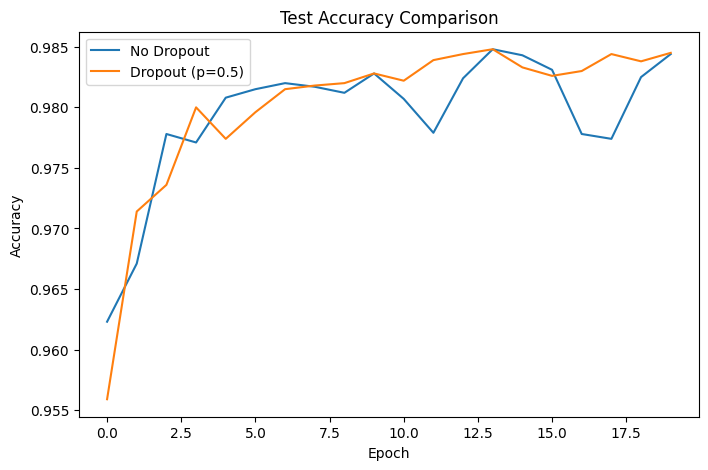

In [6]:
# Plot accuracy
plt.figure(figsize=(8,5))
for name, res in results.items():
    plt.plot(res[2], label=name)
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

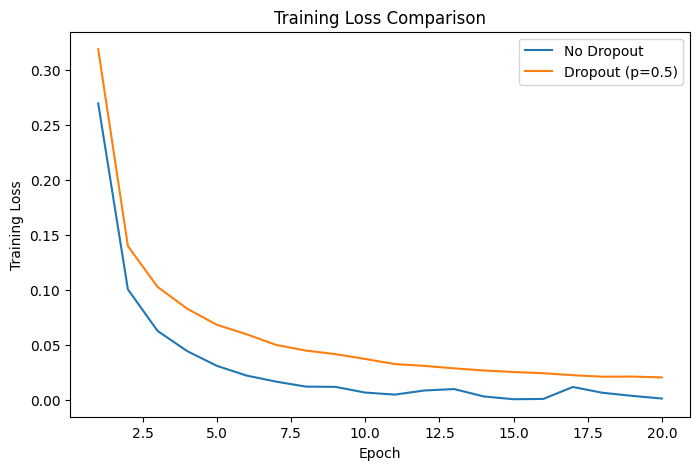

In [8]:
epochs = range(1, 21)
no_dropout_loss = results["No Dropout"][0]
dropout_loss = results["Dropout (p=0.5)"][0]

plt.figure(figsize=(8,5))
plt.plot(epochs, no_dropout_loss, label="No Dropout")
plt.plot(epochs, dropout_loss, label="Dropout (p=0.5)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

### **Summary of Results**

To evaluate the impact of dropout on model performance, two models were trained on MNIST:

**Model A** — No Dropout <br>
**Model B** — Dropout (p = 0.5)

Both models were trained for 20 epochs using the same optimizer, batch size, and architecture (except for dropout). Below are the training loss and test accuracy values recorded after each epoch.

#### **Training Loss**

The **No Dropout model** showed a **clear tendency to overfit the training data**, achieving a significantly lower loss across all epochs compared to the Dropout model.

* **No Dropout**: The training loss drops extremely fast, reaching near-zero values. This indicates the model is memorizing the training set efficiently.
* **Dropout (p=0.5)**: The training loss remains consistently higher. This is the expected cost of regularization; the Dropout layers intentionally introduce noise, making it harder for the model to perfectly fit the training set.


#### **Test Accuracy**

The **Dropout model** demonstrated **better overall generalization** by the end of the 20 epochs, effectively mitigating the overfitting observed in the unregularized model.

* **No Dropout**: The Test Accuracy curve shows clear signs of instability and overfitting. After peaking around Epoch 14-15, the accuracy begins to fluctuate and dip significantly, indicating that the extremely low training loss is not translating into stable performance on unseen data.
* **Dropout (p=0.5)**: The Test Accuracy curve is much smoother and more stable. It continues to improve steadily over the entire duration, matching the peak accuracy of the No Dropout model at Epoch 14 and ultimately achieving a stable final accuracy.

Overall, the **Dropout model** provides **more robust and consistent performance**, suggesting it will generalize better on average compared to the volatile No Dropout model.

### **Analysis and Insights**

The results confirm that the unregularized model suffered from overfitting. The No Dropout model's training loss plummeted to $\mathbf{0.0017}$ by Epoch 20. This near-zero loss confirms the model had almost perfectly memorized the training data, including any noise or unique patterns. The high capacity allowed the model's test accuracy to become unstable and volatile. After peaking at $\mathbf{0.9848}$ (Epoch 14), it began a visible decline and fluctuation (e.g., dropping to $0.9774$ by Epoch 18). This sharp divergence between falling training loss and volatile test accuracy is the signature sign of overfitting. The model's excellent performance on the training set did not reliably translate to unseen test data.

The Dropout model demonstrates that regularization leads to a more robust, stable model. The Dropout model maintains a much higher training loss ($\mathbf{0.0208}$ at Epoch 20). This cost is intentional; the $p=0.5$ rate ensures that the network cannot rely on any single set of features, preventing full memorization. Despite the higher training loss, the Dropout model's test accuracy curve is significantly smoother and more stable across the 20 epochs. It reaches a competitive peak and maintains a high final value ($\mathbf{0.9845}$), which is consistent and reliable.

### **Conclusion**

The experiment validates **Dropout** as an **effective regularization method**. The No Dropout model achieved a near-zero training loss ($\mathbf{0.0017}$), indicating full memorization, but its test accuracy was unstable and volatile, confirming overfitting. The Dropout model, despite a higher training loss ($\mathbf{0.0208}$), maintained a smoother and more stable test accuracy curve, leading to a robust final performance ($\mathbf{0.9845}$) that was superior to the unregularized model's reliability. Dropout successfully sacrifices minimal training performance to achieve better generalization on unseen data.

### **References**

1. Piyush Kashyap, Understanding Dropout in Deep Learning: A Guide to Reducing Overfitting (https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575) <br>
2. Towards Data Science, Dropout in Neural Networks (https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9/) <br>
3. GeeksForGeeks, Dropout Regularization in Deep Learning (https://www.geeksforgeeks.org/deep-learning/dropout-regularization-in-deep-learning/) <br>